In [2]:
%load_ext autoreload
%autoreload 2

In [6]:
import os
import time
import datetime
import glob
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scprep
import graphtools as gt
import phate
from scipy import sparse
from scipy.stats import zscore 
from scipy.stats import gaussian_kde

# from geomloss import SamplesLoss

# import torch 
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim

import warnings
import sys

import os
import sys
from pathlib import Path

import ot
import ot.plot
import seaborn as sns

sys.path.append('..')
from single_cell_analysis import datasets

plt.rc('font', size = 8)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['legend.frameon']=False
sns.set_style("ticks")

sys.path.append('..')
from single_cell_analysis import datasets
from single_cell_analysis.datasets import sciplex, yale_sars_crispr


In [14]:
data_path = Path('/gpfs/ycga/sequencers/pacbio/gw92/10x/data_sent/maa252/091020')
yale = yale_sars_crispr.YaleSarsCrispr(data_path, preprocess=True, ignore_cache=True, cache_dir='.').dataset

/home/myn2/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/myn2/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Ncells=0 have >10percent mt expression
Ncells=1552 have <200 genes expressed
Ngenes=14334 have <3 genes expressed


... storing 'feature_types' as categorical
... storing 'feature_types' as categorical


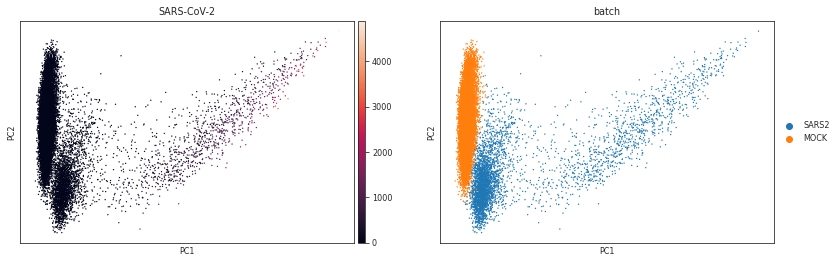

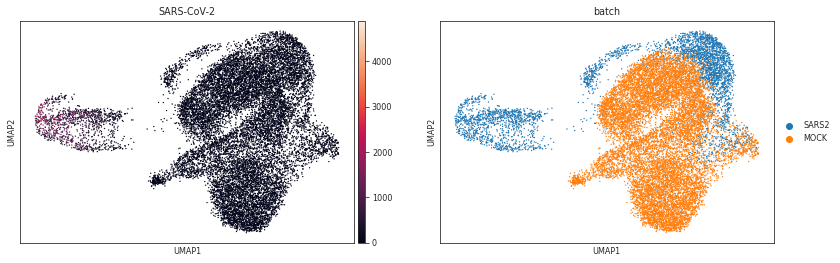

In [15]:
sc.pl.pca(yale, color=['SARS-CoV-2', 'batch'])
sc.pl.umap(yale, color=['SARS-CoV-2', 'batch'])

In [54]:
dfp = '/gpfs/ycga/sequencers/pacbio/gw92/10x/data_sent/maa252/091020/*/filtered_feature_bc_matrix/'
data_files = glob.glob(dfp)
sample_suffix = '_MON_crispr'

pfp = '/home/myn2/single-cell-analysis/results'
pdfp = '/home/myn2/single-cell-analysis/results'

if True:
    # first load
    adatas = {}
    for i, file in enumerate(data_files):
        print(file)
        if i==0:
            adata = sc.read_10x_mtx(file)
            batch_key = file.split('/filtered_')[0].split('/')[-1].split(sample_suffix)[0]
            adata.var_names_make_unique()
        else:
            adatas[file.split('/filtered_')[0].split('/')[-1].split(sample_suffix)[0]] = sc.read_10x_mtx(file)
            adatas[file.split('/filtered_')[0].split('/')[-1].split(sample_suffix)[0]].var_names_make_unique()

    adata = adata.concatenate(*adatas.values(), batch_categories=[batch_key]+list(adatas.keys()))
    del adatas
    
    sc.pp.calculate_qc_metrics(adata,inplace=True)
    mito_genes = adata.var_names.str.startswith('MT-')
    adata.obs['pmito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
    print('Ncells=%d have >10percent mt expression' % np.sum(adata.obs['pmito']>0.1))
    print('Ncells=%d have <200 genes expressed' % np.sum(adata.obs['n_genes_by_counts']<200))
    print('Ngenes=%d have <3 genes expressed' % np.sum(adata.var['n_cells_by_counts'] < 3))
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3) # filtering cells gets rid of some genes of interest
    adata.raw = adata
    if False:
        # filter 
        adata = adata[adata.obs.pmito <= 0.1, :]
    sc.pp.normalize_total(adata)
    sc.pp.sqrt(adata)
    sc.tl.pca(adata, n_comps=100)
    
    if True :
        # save
        adata.write(os.path.join(pdfp,'crispr_shallow.h5ad'))
        print('\n... saved @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
        
else:
    adata = sc.read_h5ad(os.path.join(pdfp,'crispr_shallow.h5ad'))

/gpfs/ycga/sequencers/pacbio/gw92/10x/data_sent/maa252/091020/SARS2_MON_crispr/filtered_feature_bc_matrix/
/gpfs/ycga/sequencers/pacbio/gw92/10x/data_sent/maa252/091020/MOCK_MON_crispr/filtered_feature_bc_matrix/


/home/myn2/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/myn2/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Ncells=0 have >10percent mt expression
Ncells=1552 have <200 genes expressed
Ngenes=14334 have <3 genes expressed


... storing 'feature_types' as categorical
... storing 'feature_types' as categorical



... saved @210607.13:55:33


In [5]:
adata.shape

(16585, 15125)

In [6]:
adata.obs

,batch,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,pmito,n_genes
AAACCCAAGGTAATCA-1-SARS2,SARS2,1064,6.970730,1981.0,7.591862,26.249369,37.607269,50.782433,71.529531,0.0,1064
AAACCCAAGTTGGAGC-1-SARS2,SARS2,1699,7.438384,4330.0,8.373553,28.729792,38.568129,49.838337,68.729792,0.0,1699
AAACCCAGTGGTGATG-1-SARS2,SARS2,1068,6.974479,1895.0,7.547502,25.171504,35.567282,48.601583,70.026385,0.0,1068
AAACGAAAGACCCGCT-1-SARS2,SARS2,1054,6.961296,1781.0,7.485492,22.852330,33.576642,46.715328,68.893880,0.0,1054
AAACGAAAGGAAAGGT-1-SARS2,SARS2,1310,7.178545,2615.0,7.869402,26.118547,36.596558,48.986616,69.024857,0.0,1310
...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTGTTTGCA-1-MOCK,MOCK,283,5.648974,373.0,5.924256,37.533512,50.938338,77.747989,100.000000,0.0,283
TTTGTTGTCACCGCTT-1-MOCK,MOCK,383,5.950643,509.0,6.234411,30.058939,44.400786,64.047151,100.000000,0.0,383
TTTGTTGTCCACTTTA-1-MOCK,MOCK,331,5.805135,416.0,6.033086,32.451923,44.471154,68.509615,100.000000,0.0,331
TTTGTTGTCTCCGAGG-1-MOCK,MOCK,556,6.322565,1051.0,6.958448,39.010466,52.331113,66.127498,94.671741,0.0,556


In [7]:
adata.obs.batch

AAACCCAAGGTAATCA-1-SARS2    SARS2
AAACCCAAGTTGGAGC-1-SARS2    SARS2
AAACCCAGTGGTGATG-1-SARS2    SARS2
AAACGAAAGACCCGCT-1-SARS2    SARS2
AAACGAAAGGAAAGGT-1-SARS2    SARS2
                            ...  
TTTGTTGGTGTTTGCA-1-MOCK      MOCK
TTTGTTGTCACCGCTT-1-MOCK      MOCK
TTTGTTGTCCACTTTA-1-MOCK      MOCK
TTTGTTGTCTCCGAGG-1-MOCK      MOCK
TTTGTTGTCTTAGCTT-1-MOCK      MOCK
Name: batch, Length: 16585, dtype: category
Categories (2, object): ['SARS2', 'MOCK']

In [8]:
adata

AnnData object with n_obs × n_vars = 16585 × 15125
    obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pmito', 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [9]:
guide_mappings = glob.glob('/gpfs/ycga/sequencers/pacbio/gw92/10x/data_sent/maa252/091020/*/crispr_analysis/protospacer_calls_per_cell.csv')
guide_mappings

['/gpfs/ycga/sequencers/pacbio/gw92/10x/data_sent/maa252/091020/SARS2_MON_crispr/crispr_analysis/protospacer_calls_per_cell.csv',
 '/gpfs/ycga/sequencers/pacbio/gw92/10x/data_sent/maa252/091020/MOCK_MON_crispr/crispr_analysis/protospacer_calls_per_cell.csv']

In [10]:
mock_map = pd.read_csv('/gpfs/ycga/sequencers/pacbio/gw92/10x/data_sent/maa252/091020/MOCK_MON_crispr/crispr_analysis/protospacer_calls_per_cell.csv')
sars_map = pd.read_csv('/gpfs/ycga/sequencers/pacbio/gw92/10x/data_sent/maa252/091020/SARS2_MON_crispr/crispr_analysis/protospacer_calls_per_cell.csv')

In [11]:
sars_map

,cell_barcode,num_features,feature_call,num_umis
0,GAAGGGTGTTGCCGAC-1,1,ACE2-1,55
1,TCCCACAAGCCTTTCC-1,1,ACE2-1,5
2,GCCAACGGTCTGATCA-1,1,ACE2-1,26
3,GTACAACGTTGGAGGT-1,1,ACE2-1,43
4,GTCTGTCTCTGCCCTA-1,1,ACE2-1,34
...,...,...,...,...
2922,AAGTTCGTCACATTGG-1,1,UBXN7-4,97
2923,TGGAACTAGCAAGCCA-1,1,UBXN7-4,97
2924,GTCTTTATCCAAAGGG-1,1,UBXN7-4,71
2925,TGCGATAGTCGTCGGT-1,3,UBXN7-4|DOLK-2|PHF6-3,119|21|3


In [12]:
sars_map.groupby('cell_barcode').count()

,num_features,feature_call,num_umis
cell_barcode,,,
AAACCCAAGGTAATCA-1,1,1,1
AAACCCAAGTTGGAGC-1,1,1,1
AAACGAAAGACCCGCT-1,1,1,1
AAACGAAAGGAAAGGT-1,1,1,1
AAACGAACACCGTGAC-1,1,1,1
...,...,...,...
TTTGGAGTCTAGTTCT-1,1,1,1
TTTGGTTAGATCGCTT-1,1,1,1
TTTGGTTAGTGATGGC-1,1,1,1


/home/myn2/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Number of guides detected (MOCK)')

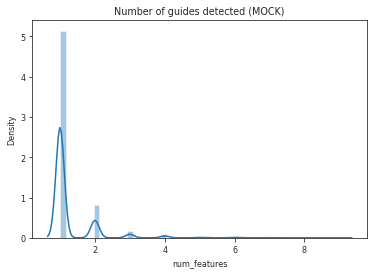

In [13]:
p = sns.distplot(mock_map['num_features'])
p.set_title('Number of guides detected (MOCK)')

/home/myn2/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Number of guides detected (2dpi)')

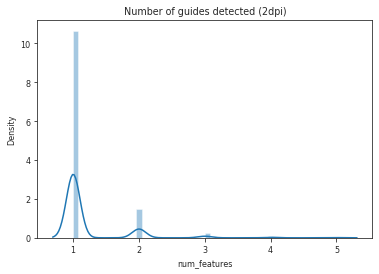

In [14]:
p = sns.distplot(sars_map['num_features'])
p.set_title('Number of guides detected (2dpi)')

In [15]:
print(adata)
adata.obs.groupby('batch').count()

AnnData object with n_obs × n_vars = 16585 × 15125
    obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pmito', 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'


,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,pmito,n_genes
batch,,,,,,,,,,
SARS2,4098,4098,4098,4098,4098,4098,4098,4098,4098,4098
MOCK,12487,12487,12487,12487,12487,12487,12487,12487,12487,12487


/home/myn2/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


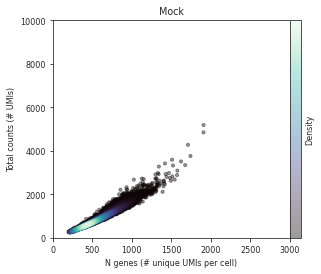

In [16]:
sample = 'Mock'
mock = adata[adata.obs['batch']==sample.upper(), :]

# Generate fake data
x = mock.obs['n_genes_by_counts'].to_numpy()
y = mock.obs['total_counts'].to_numpy()

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots(1,1, figsize=(5,4))
im = ax.scatter(x, y, 
                c=z,
                alpha=0.4,
                s=10, 
                cmap='mako', 
                rasterized=True)
ax.set_title(sample)
ax.set_ylim([0,10000])
ax.set_xlim([0,3000])
ax.set_xlabel('N genes (# unique UMIs per cell)')
ax.set_ylabel('Total counts (# UMIs)')
fig.colorbar(im, pad=0, label='Density', ticks=[])


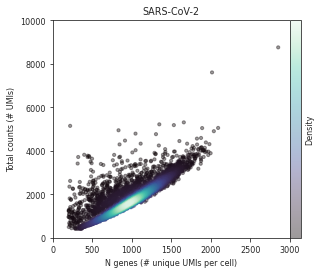

In [17]:
sample = 'SARS-CoV-2'
sars = adata[adata.obs['batch']=='SARS2', :]

# Generate fake data
x = sars.obs['n_genes_by_counts'].to_numpy()
y = sars.obs['total_counts'].to_numpy()

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots(1,1, figsize=(5,4))
im = ax.scatter(x, y, 
                c=z,
                alpha=0.4,
                s=10, 
                cmap='mako', 
                rasterized=True)
ax.set_title(sample)
ax.set_xlabel('N genes (# unique UMIs per cell)')
ax.set_ylabel('Total counts (# UMIs)')
ax.set_ylim([0,10000])
ax.set_xlim([0,3000])
fig.colorbar(im, pad=0, label='Density', ticks=[])


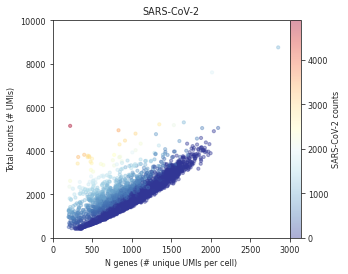

In [18]:
sample = 'SARS-CoV-2'

# Generate fake data
x = sars.obs['n_genes_by_counts'].to_numpy()
y = sars.obs['total_counts'].to_numpy()

fig, ax = plt.subplots(1,1, figsize=(5,4))
im = ax.scatter(x, y, 
                c=np.asarray(sars.raw[:, 'SARS-CoV-2'].X.todense()).flatten(),
                alpha=0.4,
                s=10, 
                cmap='RdYlBu_r', 
                rasterized=True)
ax.set_title(sample)
ax.set_xlabel('N genes (# unique UMIs per cell)')
ax.set_ylabel('Total counts (# UMIs)')
ax.set_ylim([0,10000])
ax.set_xlim([0,3000])
fig.colorbar(im, pad=0, label='SARS-CoV-2 counts',)


In [19]:
adata

AnnData object with n_obs × n_vars = 16585 × 15125
    obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pmito', 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

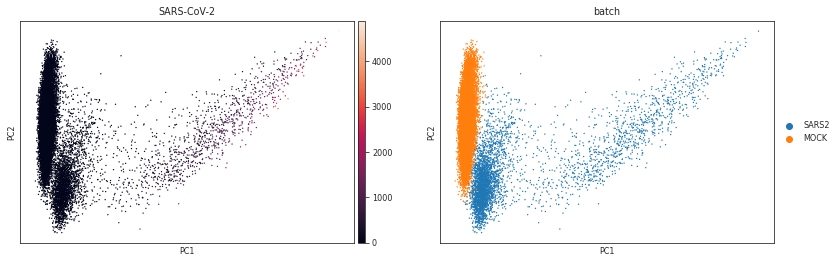

In [20]:
sc.pl.pca(adata, color=['SARS-CoV-2', 'batch'])

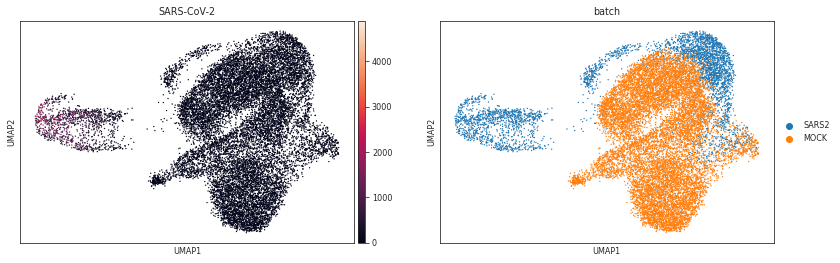

In [21]:
sc.external.pp.bbknn(adata, neighbors_within_batch=15, n_pcs=50)

sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['SARS-CoV-2', 'batch'])

In [22]:
sars.obs['Viral counts (raw)'] = sars.raw[:, 'SARS-CoV-2'].X.todense()

Trying to set attribute `.obs` of view, copying.


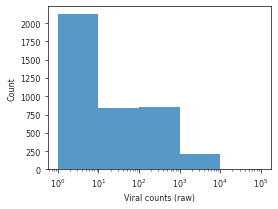

In [23]:
fig, ax = plt.subplots(1,1,figsize=(4,3))
sns.histplot(sars.obs.loc[sars.obs['Viral counts (raw)']>0, 'Viral counts (raw)'], bins=[0,1,1e1,1e2,1e3,1e4,1e5], ax=ax)
ax.set_xscale('log')

/home/myn2/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Viral counts (raw)', ylabel='Density'>

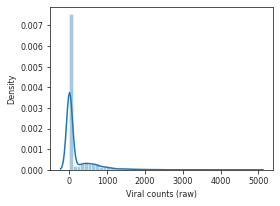

In [24]:
fig, ax = plt.subplots(1,1,figsize=(4,3))
sns.distplot(sars.obs.loc[sars.obs['Viral counts (raw)']>0, 'Viral counts (raw)'], ax=ax)
# ax.set_xscale('log')

In [25]:
sars.obs['geq10'] = 'Bystander'
sars.obs.loc[sars.obs['Viral counts (raw)']>=10, 'geq10'] = 'Infected' 

sars.obs['geq1'] = 'Bystander'
sars.obs.loc[sars.obs['Viral counts (raw)']>=1, 'geq1'] = 'Infected' 

sars.obs['geq100'] = 'Bystander'
sars.obs.loc[sars.obs['Viral counts (raw)']>=100, 'geq100'] = 'Infected' 

Text(0, 0.5, 'Proportion of cells in SARS-CoV-2 sample')

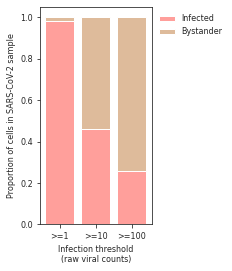

In [26]:
fig, ax = plt.subplots(1,1, figsize=(2,4))
infected_bars = [(sars.obs['geq1']=='Infected').sum()/sars.shape[0],
                 (sars.obs['geq10']=='Infected').sum()/sars.shape[0],
                 (sars.obs['geq100']=='Infected').sum()/sars.shape[0],]
bystander_bars = [(sars.obs['geq1']=='Bystander').sum()/sars.shape[0],
                  (sars.obs['geq10']=='Bystander').sum()/sars.shape[0],
                  (sars.obs['geq100']=='Bystander').sum()/sars.shape[0],]
ax.bar(['>=1', '>=10', '>=100'], infected_bars,
        color=sns.color_palette('pastel')[3], label='Infected')
ax.bar(['>=1', '>=10', '>=100'], bystander_bars,
       bottom=infected_bars,
        color=sns.color_palette('pastel')[5], label='Bystander')
ax.legend(bbox_to_anchor=(1,1))

ax.set_xlabel('Infection threshold\n(raw viral counts)')
ax.set_ylabel('Proportion of cells in SARS-CoV-2 sample')
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
                          

... storing 'geq10' as categorical
... storing 'geq1' as categorical
... storing 'geq100' as categorical


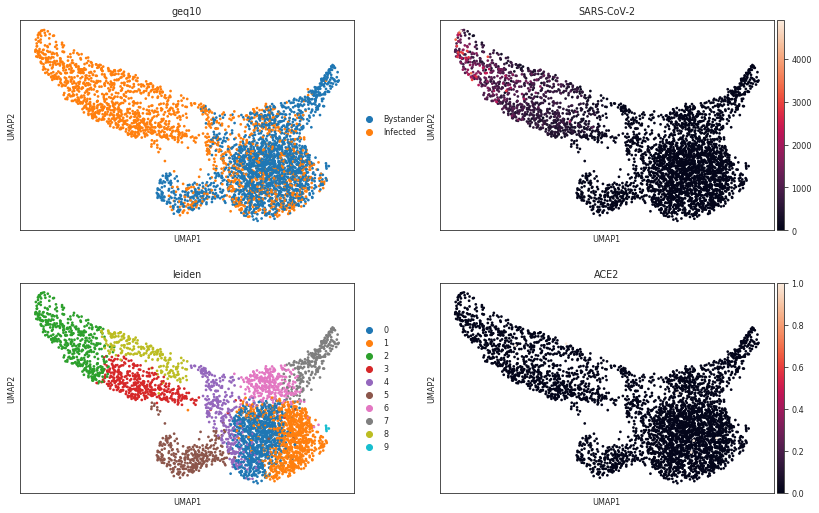

In [27]:
sc.tl.pca(sars)
sc.pp.neighbors(sars, n_pcs=50)
sc.tl.leiden(sars)
sc.tl.umap(sars)
sc.pl.umap(sars, color=['geq10', 'SARS-CoV-2', 'leiden', 'ACE2'], ncols=2)

# Guide mapping

In [28]:
sars.obs.index

Index(['AAACCCAAGGTAATCA-1-SARS2', 'AAACCCAAGTTGGAGC-1-SARS2',
       'AAACCCAGTGGTGATG-1-SARS2', 'AAACGAAAGACCCGCT-1-SARS2',
       'AAACGAAAGGAAAGGT-1-SARS2', 'AAACGAACACCGTGAC-1-SARS2',
       'AAACGCTAGACGACTG-1-SARS2', 'AAACGCTAGCACCAGA-1-SARS2',
       'AAACGCTAGCGGTATG-1-SARS2', 'AAACGCTAGTAAAGCT-1-SARS2',
       ...
       'TTTGGAGGTCTCTCTG-1-SARS2', 'TTTGGAGGTGCCTTCT-1-SARS2',
       'TTTGGAGTCTAGTTCT-1-SARS2', 'TTTGGTTAGATCGCTT-1-SARS2',
       'TTTGGTTAGTGATGGC-1-SARS2', 'TTTGGTTCAATGCAGG-1-SARS2',
       'TTTGGTTGTGAGCAGT-1-SARS2', 'TTTGTTGCATCGTGCG-1-SARS2',
       'TTTGTTGGTTTCCCAC-1-SARS2', 'TTTGTTGTCACTGATG-1-SARS2'],
      dtype='object', length=4098)

sars_map

In [29]:
sars_map.feature_call.unique()

array(['ACE2-1', 'ACE2-1|ACE2-3|KDM6A-4', 'ACE2-1|KDM6A-2',
       'ACE2-1|Non-Targeting-5|ACE2-2', 'ACE2-1|Non-Targeting-7',
       'ACE2-1|PCBD1-2', 'ACE2-1|PIAS1-4', 'ACE2-1|SMARCA5-3',
       'ACE2-1|SMARCE1-3', 'ACE2-1|UBXN7-3', 'ACE2-2',
       'ACE2-2|ACE2-3|Non-Targeting-10', 'ACE2-2|ARID1A-1',
       'ACE2-2|ARID1A-3|Non-Targeting-10|PCBD1-4|PIAS2-1',
       'ACE2-2|DOLK-1', 'ACE2-2|PCBD1-3', 'ACE2-2|PCBD1-4',
       'ACE2-2|PHF6-4', 'ACE2-2|PIAS1-2', 'ACE2-2|RAD54L2-2',
       'ACE2-2|SMAD3-3', 'ACE2-2|TMPRSS4-1', 'ACE2-2|TMPRSS4-1|ARID1A-2',
       'ACE2-3', 'ACE2-3|PCBD1-1', 'ACE2-3|PHF6-2', 'ACE2-3|PHF6-3',
       'ACE2-3|PHF6-4', 'ACE2-3|RAD54L2-2|PHF6-2', 'ACE2-3|RAD54L2-4',
       'ACE2-3|SMAD4-2', 'ACE2-4', 'ACE2-4|ACE2-2', 'ACE2-4|ATRX-3',
       'ACE2-4|CABIN1-4|CABIN1-3|Non-Targeting-10',
       'ACE2-4|DPF2-2|SMARCA5-1', 'ACE2-4|DPF2-2|UBXN7-3|SMARCA5-1',
       'ACE2-4|KDM6A-3', 'ACE2-4|KDM6A-4|PHF6-4', 'ACE2-4|TMPRSS4-1',
       'ACVR1B-1', 'ACVR1B-1|PCBD1-2', 'A

In [30]:
sars_map

,cell_barcode,num_features,feature_call,num_umis
0,GAAGGGTGTTGCCGAC-1,1,ACE2-1,55
1,TCCCACAAGCCTTTCC-1,1,ACE2-1,5
2,GCCAACGGTCTGATCA-1,1,ACE2-1,26
3,GTACAACGTTGGAGGT-1,1,ACE2-1,43
4,GTCTGTCTCTGCCCTA-1,1,ACE2-1,34
...,...,...,...,...
2922,AAGTTCGTCACATTGG-1,1,UBXN7-4,97
2923,TGGAACTAGCAAGCCA-1,1,UBXN7-4,97
2924,GTCTTTATCCAAAGGG-1,1,UBXN7-4,71
2925,TGCGATAGTCGTCGGT-1,3,UBXN7-4|DOLK-2|PHF6-3,119|21|3


In [32]:
mock_map

,cell_barcode,num_features,feature_call,num_umis
0,GAGTCTAGTTCCCACT-1,1,ACE2-1,24
1,CTACAGAGTGCTCTTC-1,1,ACE2-1,15
2,TATTCCACACTTGTGA-1,1,ACE2-1,12
3,GTAGATCCAATTGCTG-1,1,ACE2-1,23
4,TTGCATTGTACGCGTC-1,1,ACE2-1,37
...,...,...,...,...
6701,ACTTTCAAGTACAACA-1,2,UBXN7-4|LOC103223006-3,11|18
6702,ACAAGCTCAGGTCTCG-1,2,UBXN7-4|LOC103223006-4,24|51
6703,TGCGACGAGGGAGGGT-1,2,UBXN7-4|PIAS2-4,151|10
6704,CACAGGCGTTAGTTCG-1,2,UBXN7-4|TMPRSS2-1,98|6


In [31]:
sars.obs.index = [i.split('-SARS2')[0] for i in sars.obs.index]
sars_map.index = sars_map['cell_barcode']
sars.obs = sars.obs.merge(sars_map.loc[sars_map['num_features']==1, ['feature_call']], left_index=True, right_index=True, how='left')


In [32]:
sars.obs['feature_call']

AAACCCAAGGTAATCA-1       ACE2-4
AAACCCAAGTTGGAGC-1      KDM6A-1
AAACCCAGTGGTGATG-1          NaN
AAACGAAAGACCCGCT-1    SMARCA4-1
AAACGAAAGGAAAGGT-1          NaN
                        ...    
TTTGGTTCAATGCAGG-1          NaN
TTTGGTTGTGAGCAGT-1          NaN
TTTGTTGCATCGTGCG-1          NaN
TTTGTTGGTTTCCCAC-1          NaN
TTTGTTGTCACTGATG-1     CABIN1-2
Name: feature_call, Length: 4098, dtype: object

... storing 'feature_call' as categorical


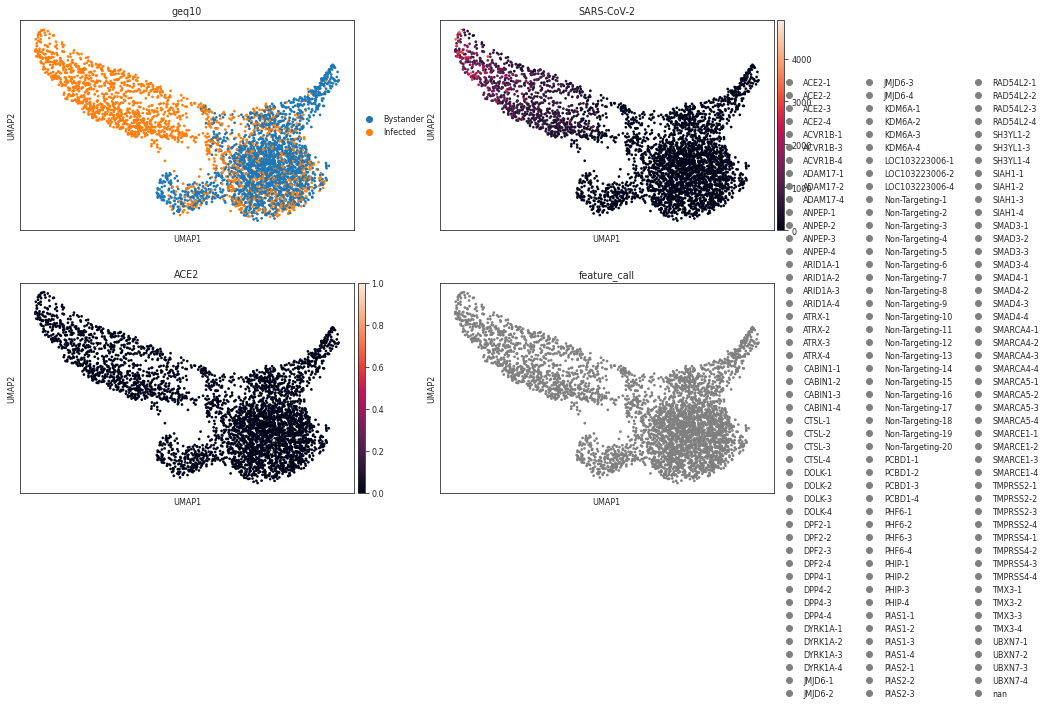

In [33]:
sc.pl.umap(sars, color=['geq10', 'SARS-CoV-2', 'ACE2', 'feature_call'], ncols=2)

In [34]:
# merge both 
mock_map['cell_barcode'].isin(sars_map['cell_barcode']).sum()

8

In [35]:
adata.obs

,batch,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,pmito,n_genes,leiden
AAACCCAAGGTAATCA-1-SARS2,SARS2,1064,6.970730,1981.0,7.591862,26.249369,37.607269,50.782433,71.529531,0.0,1064,3
AAACCCAAGTTGGAGC-1-SARS2,SARS2,1699,7.438384,4330.0,8.373553,28.729792,38.568129,49.838337,68.729792,0.0,1699,2
AAACCCAGTGGTGATG-1-SARS2,SARS2,1068,6.974479,1895.0,7.547502,25.171504,35.567282,48.601583,70.026385,0.0,1068,9
AAACGAAAGACCCGCT-1-SARS2,SARS2,1054,6.961296,1781.0,7.485492,22.852330,33.576642,46.715328,68.893880,0.0,1054,3
AAACGAAAGGAAAGGT-1-SARS2,SARS2,1310,7.178545,2615.0,7.869402,26.118547,36.596558,48.986616,69.024857,0.0,1310,3
...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTGTTTGCA-1-MOCK,MOCK,283,5.648974,373.0,5.924256,37.533512,50.938338,77.747989,100.000000,0.0,283,1
TTTGTTGTCACCGCTT-1-MOCK,MOCK,383,5.950643,509.0,6.234411,30.058939,44.400786,64.047151,100.000000,0.0,383,0
TTTGTTGTCCACTTTA-1-MOCK,MOCK,331,5.805135,416.0,6.033086,32.451923,44.471154,68.509615,100.000000,0.0,331,0
TTTGTTGTCTCCGAGG-1-MOCK,MOCK,556,6.322565,1051.0,6.958448,39.010466,52.331113,66.127498,94.671741,0.0,556,4


In [36]:
mock_map.index = [i+'-MOCK' for i in mock_map['cell_barcode']]
sars_map.index = [i+'-SARS2' for i in sars_map['cell_barcode']]
mapping = pd.concat([mock_map, sars_map])
adata.obs = adata.obs.merge(mapping.loc[mapping['num_features']==1, ['feature_call']], left_index=True, right_index=True, how='left')


In [37]:
adata.obs['raw_scv2'] = np.asarray(adata.raw[:, 'SARS-CoV-2'].X.todense()).flatten()
adata.obs['Infected'] = 'Mock'
adata.obs.loc[((adata.obs['raw_scv2']>=10) & (adata.obs['batch']=='SARS2')), 'Infected'] = 'Infected'
adata.obs.loc[((adata.obs['raw_scv2']<10) & (adata.obs['batch']=='SARS2')), 'Infected'] = 'Bystander'

In [38]:
adata.obs['new_feature_call'] = [i.split('-')[0] if ('Targeting' not in i) else i for i in adata.obs['feature_call'].fillna('None')]

In [39]:
if True:
    # customize list
    goi =  [
        'ACE2',
        'UBXN7',
    #     'JMJD6',
    #     'ATRX',
    #     'PCBD1',
    #     'DPF2',
        'CTSL',
    #     'PHIP',
    #     'ACVR1B',
    #     'ARID1A',
    #     'TMX3',
        'DPP4',
    #     'PIAS2',
    #     'RAD54L2',
        'ANPEP',
        'DYRK1A',
        'SMAD3',
    #     'PIAS1',
    #     'SIAH1',
    #     'ADAM17',
    #     'PHF6',
        'TMPRSS4',
    #     'SMARCE1',
    #     'CABIN1',
    #     'DOLK',
        'TMPRSS2',
        'SMARCA5',
    #     'LOC103223006',
    ]
else:
    goi = []
    for i in adata.obs.new_feature_call.unique():
        if 'Targeting' not in i and 'None' not in i:
            goi.append(i)

adata.obs['sgRNA'] = 'Other guide'
adata.obs.loc[adata.obs['feature_call'].isna(), 'sgRNA'] = 'None'
for g in goi:
    adata.obs.loc[adata.obs['new_feature_call']==g, 'sgRNA'] = g

/home/myn2/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/myn2/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'feature_call' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Infected' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'new_feature_call' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sgRNA' as categorical


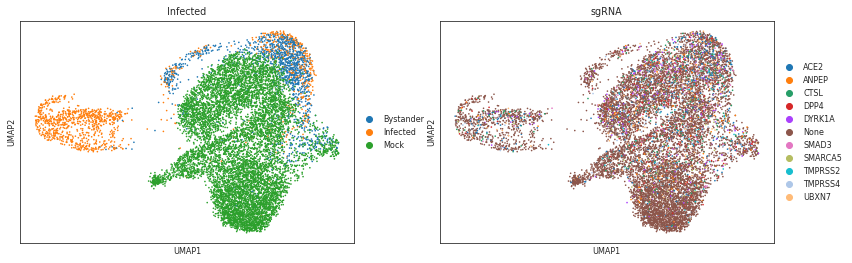

In [40]:
sc.pl.umap(adata[adata.obs['sgRNA']!='Other guide', :], color=['Infected', 'sgRNA'], ncols=2)

In [41]:
cmap_guide = {v:sns.color_palette()[i] for i,v in enumerate(goi)}
cmap_guide['Other guide'] = '#DCDBE2'
cmap_guide['None'] = '#E5E5E5'

In [42]:
adata.obs['size'] = 4
adata.obs.loc[(adata.obs['sgRNA']=='Other guide') | (adata.obs['sgRNA']=='None'), 'size'] = 1

/home/myn2/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


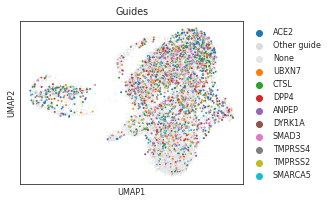

In [43]:
fig, ax = plt.subplots(1,1, figsize=(4,3))
sns.scatterplot(
    x=adata.obsm['X_umap'][:,0],
    y=adata.obsm['X_umap'][:,1],
    hue=adata.obs['sgRNA'].astype(str),
    style=None,
    size=None,
    data=None,
    palette=cmap_guide,
    hue_order=None,
    hue_norm=None,
    sizes=None,
    size_order=None,
    size_norm=None,
    markers=True,
    style_order=None,
    x_bins=None,
    y_bins=None,
    units=None,
    estimator=None,
    ci=95,
    n_boot=1000,
    alpha=None,
    x_jitter=None,
    y_jitter=None,
    legend='auto',
    ax=ax,
    linewidth=0,
    s=adata.obs['size'].astype(float),
    rasterized=True,
)
ax.legend(bbox_to_anchor=(1,1))
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('Guides')
fig.savefig(os.path.join(pfp, 'umap_guides_of_interest.png'), dpi=600, bbox_inches='tight')

In [46]:
pfp

'/home/myn2/single-cell-analysis/results'

... storing 'feature_call' as categorical
... storing 'Infected' as categorical
... storing 'new_feature_call' as categorical
... storing 'sgRNA' as categorical


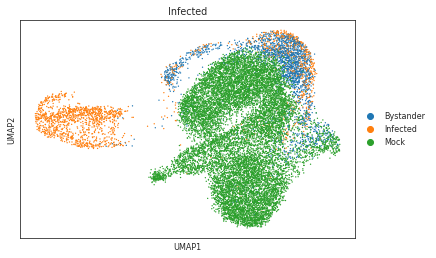

In [44]:
sc.settings.figdir = pfp
sc.pl.umap(adata, color=['Infected'], save='_infection.png')

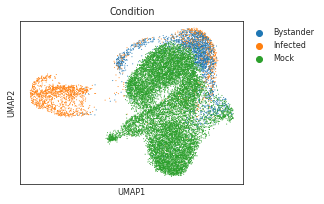

In [45]:
fig, ax = plt.subplots(1,1, figsize=(4,3))
sns.scatterplot(
    x=adata.obsm['X_umap'][:,0],
    y=adata.obsm['X_umap'][:,1],
    hue=adata.obs['Infected'].astype(str),
    style=None,
    size=None,
    data=None,
#     palette=cmap_guide,
    hue_order=None,
    hue_norm=None,
    sizes=None,
    size_order=None,
    size_norm=None,
    markers=True,
    style_order=None,
    x_bins=None,
    y_bins=None,
    units=None,
    estimator=None,
    ci=95,
    n_boot=1000,
    alpha=None,
    x_jitter=None,
    y_jitter=None,
    legend='auto',
    ax=ax,
    linewidth=0,
    s=1, #adata.obs['size'].astype(float),
    rasterized=True,
)
ax.legend(bbox_to_anchor=(1,1))
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('Condition')
fig.savefig(os.path.join(pfp, 'umap_infection.png'), dpi=600, bbox_inches='tight')

In [46]:
adata.obs

,batch,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,pmito,n_genes,leiden,feature_call,raw_scv2,Infected,new_feature_call,sgRNA,size
AAACCCAAGGTAATCA-1-SARS2,SARS2,1064,6.970730,1981.0,7.591862,26.249369,37.607269,50.782433,71.529531,0.0,1064,3,ACE2-4,1.0,Bystander,ACE2,ACE2,4
AAACCCAAGTTGGAGC-1-SARS2,SARS2,1699,7.438384,4330.0,8.373553,28.729792,38.568129,49.838337,68.729792,0.0,1699,2,KDM6A-1,4.0,Bystander,KDM6A,Other guide,1
AAACCCAGTGGTGATG-1-SARS2,SARS2,1068,6.974479,1895.0,7.547502,25.171504,35.567282,48.601583,70.026385,0.0,1068,9,nan,14.0,Infected,None,None,1
AAACGAAAGACCCGCT-1-SARS2,SARS2,1054,6.961296,1781.0,7.485492,22.852330,33.576642,46.715328,68.893880,0.0,1054,3,SMARCA4-1,2.0,Bystander,SMARCA4,Other guide,1
AAACGAAAGGAAAGGT-1-SARS2,SARS2,1310,7.178545,2615.0,7.869402,26.118547,36.596558,48.986616,69.024857,0.0,1310,3,nan,11.0,Infected,None,None,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTGTTTGCA-1-MOCK,MOCK,283,5.648974,373.0,5.924256,37.533512,50.938338,77.747989,100.000000,0.0,283,1,nan,0.0,Mock,None,None,1
TTTGTTGTCACCGCTT-1-MOCK,MOCK,383,5.950643,509.0,6.234411,30.058939,44.400786,64.047151,100.000000,0.0,383,0,nan,0.0,Mock,None,None,1
TTTGTTGTCCACTTTA-1-MOCK,MOCK,331,5.805135,416.0,6.033086,32.451923,44.471154,68.509615,100.000000,0.0,331,0,PHF6-4,0.0,Mock,PHF6,Other guide,1
TTTGTTGTCTCCGAGG-1-MOCK,MOCK,556,6.322565,1051.0,6.958448,39.010466,52.331113,66.127498,94.671741,0.0,556,4,nan,0.0,Mock,None,None,1


In [47]:
for i in adata.obs['new_feature_call'].unique():
    print(i)
adata.obs['labels'] = [np.nan if 'None' in i or 'Non-Targ' in i else i for i in adata.obs['new_feature_call']] 

ACE2
KDM6A
None
SMARCA4
SMAD4
SH3YL1
Non-Targeting-1
UBXN7
JMJD6
Non-Targeting-9
Non-Targeting-3
ATRX
PCBD1
DPF2
CTSL
PHIP
ACVR1B
ARID1A
TMX3
DPP4
Non-Targeting-11
Non-Targeting-15
PIAS2
RAD54L2
ANPEP
Non-Targeting-18
DYRK1A
SMAD3
PIAS1
Non-Targeting-17
SIAH1
ADAM17
Non-Targeting-19
Non-Targeting-7
Non-Targeting-2
PHF6
Non-Targeting-16
TMPRSS4
SMARCE1
Non-Targeting-4
Non-Targeting-5
CABIN1
DOLK
TMPRSS2
Non-Targeting-10
Non-Targeting-6
Non-Targeting-8
SMARCA5
LOC103223006
Non-Targeting-13
Non-Targeting-20
Non-Targeting-14
Non-Targeting-12


In [48]:
for i in adata.obs['labels'].unique():
    print(i)

ACE2
KDM6A
nan
SMARCA4
SMAD4
SH3YL1
UBXN7
JMJD6
ATRX
PCBD1
DPF2
CTSL
PHIP
ACVR1B
ARID1A
TMX3
DPP4
PIAS2
RAD54L2
ANPEP
DYRK1A
SMAD3
PIAS1
SIAH1
ADAM17
PHF6
TMPRSS4
SMARCE1
CABIN1
DOLK
TMPRSS2
SMARCA5
LOC103223006


In [49]:
len(adata.obs['labels'].unique())

33

In [50]:
# save adata
if True :
    # save
    adata.write(os.path.join(pdfp,'crispr_shallow.h5ad'))
    print('\n... saved @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))

... storing 'labels' as categorical



... saved @210601.07:14:40


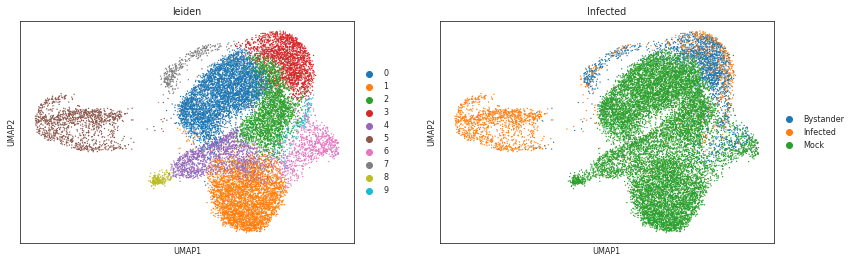

In [51]:
sc.pl.umap(adata, color=['leiden', 'Infected'])

In [52]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', key_added = "wilcoxon")

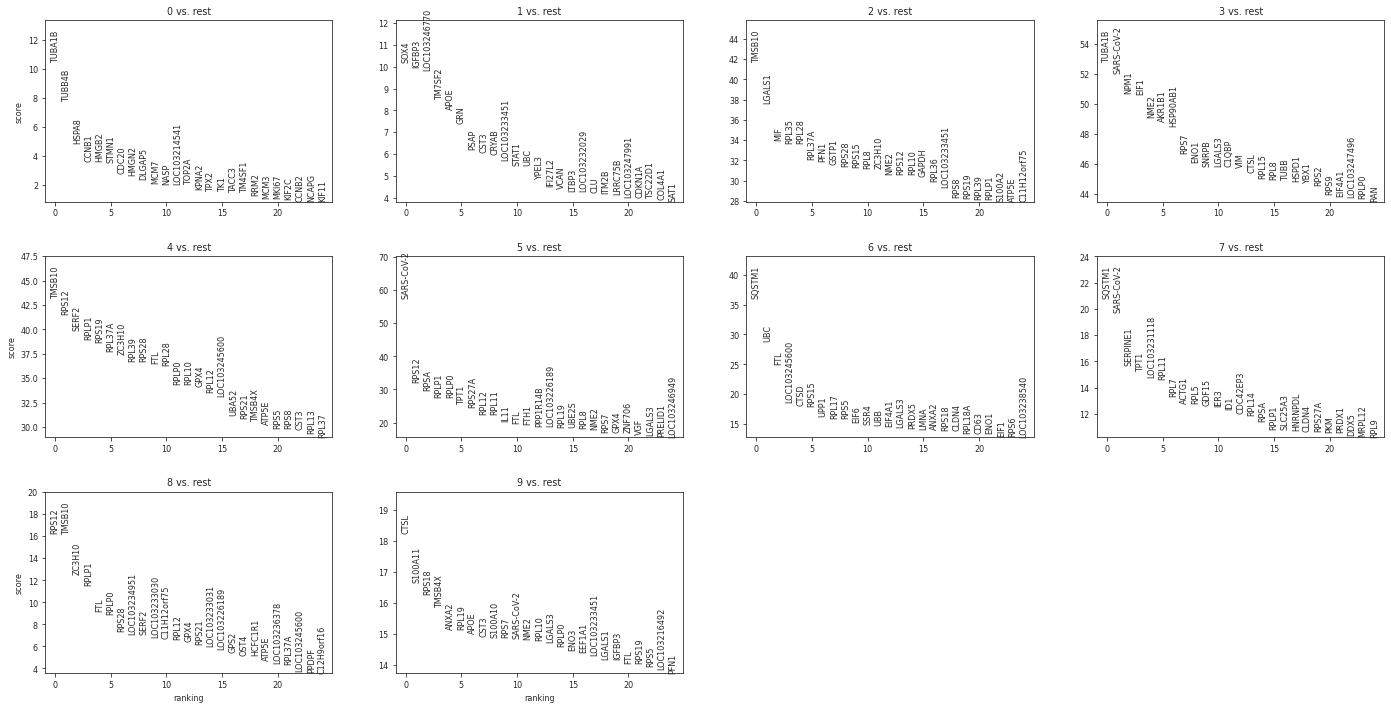

In [53]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "wilcoxon")